# Synthetic Entropy Datasets

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(root))
sys.path.append(str(pysim_root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Entropy

### Estimators

In [42]:
# !pip install "git+https://github.com/gregversteeg/NPEET.git"
# !pip install mutual-info

In [55]:
from mutual_info.mutual_info import entropy as mi_entropy
from npeet.entropy_estimators import entropy as npeet_entropy

In [16]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.histogram import hist_entropy
from pysim.information.entropy import marginal_entropy
import time


def get_entropy_estimators(data):

    t0 = time.time()
    H_g = gauss_entropy_multi(data)
    print(f"Gaussian: {H_g:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    H_knn_nbs = mi_entropy(data, k=10, transform=None)
    print(f"KNN (Neighbours): {H_knn_nbs:.4f}  | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    H_knn_eps = npeet_entropy(data, k=10, base=np.e)
    print(f"KNN (epsilon): {H_knn_eps:.4f} | Time: {time.time()-t0:.4f} secs")

## Toy Data

In [56]:
n_samples = 50_000
n_features = 1
seed = 123

### Gaussian

**Implementation Notes**:

1. We randomly generate a positive semi-definite $D \times D$ matrix. This acts as our covariance matrix $\boldsymbol{\Sigma}$.

2. We use a mean, $\boldsymbol{\mu}$ of $\mathbf{0}$.

3. We generate an upper limit of 5e5 data points and then random subset the requested number.

In [57]:
from pysim.data.information.gaussian import generate_gaussian_data


from functools import partial

In [58]:
# create seed (trial number)
res_tuple = generate_gaussian_data(
    n_samples=n_samples, n_features=n_features, seed=seed, n_base_samples=500_000,
)

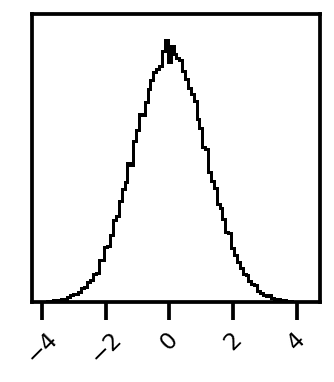

In [59]:
fig = corner.corner(res_tuple.X[:, :10], bins=100)

#### Entropy

This has a known formula:

$$
H(\mathbf{X}) = \frac{D}{2} + \frac{D}{2}\log (2\pi)+ \frac{1}{2}\log \left|\boldsymbol{\Sigma}_{\mathbf{xx}} \right|
$$

where:

* $D$ - number of features
* $\left|\cdot \right|$ - absolute determinant
* $\boldsymbol{\Sigma}_{\mathbf{xx}} \in \mathbb{R}^{D \times D}$ - covariance matrix

**Note**: This entropy measure has the units `nats`.

In [60]:
print(f"True Value: {res_tuple.H:.4f}")

True Value: 1.5448


In [61]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 1.5447 | Time: 0.0011 secs
KNN (Neighbours): 1.5454  | Time: 0.2745 secs
KNN (epsilon): 1.5454 | Time: 0.2106 secs


### Rotated Gaussian

This is similar to the above approach. We take a matrix $\mathbf{X}$ that's generated from a standard, multivariate Normal distribution and we multiply it by a random square matrix.

$$
\mathbf{Y} = \mathbf{AX}
$$

where:

* $A_{ij} \sim \mathcal{U}[0,1]$
* $\mathbf{X} \sim \mathcal{N}(\mathbf{0},\mathbf{1})$

This ensures that all correlations are positive as opposed to the above example where it is completely random.

In [62]:
from pysim.data.information.gaussian import generate_gaussian_rotation_data

In [63]:
# create seed (trial number)
res_tuple = generate_gaussian_rotation_data(
    n_samples=n_samples, n_features=n_features, seed=seed, n_base_samples=500_000,
)

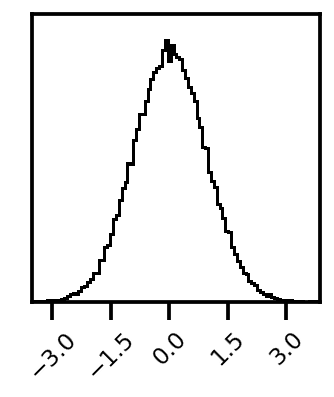

In [64]:
fig = corner.corner(res_tuple.X[:, :10], bins=100)

#### Entropy

Let $\mathbf{x} = f(\mathbf{z}) = \mathbf{Az}$.


where $\mathbf{A} \in \mathbb{R}^{D \times D}$ and $\mathbf{z}\in \mathbb{R}^{D}$. In general, we can compute the differential entropy over the invertible transformation:

$$
H(\mathbf{AX}) = H(\mathbf{Z}) + \log\left| \mathbf{A} \right|
$$

In **general**, differential entropy is not invariant to arbitrary invertible maps. It is **translation** invariant, (e.g. $a\mathbf{x})$)


In [65]:
res_tuple.H

1.340666689676585

In [66]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 1.3406 | Time: 0.0009 secs
KNN (Neighbours): 1.3413  | Time: 0.1940 secs
KNN (epsilon): 1.3413 | Time: 0.1362 secs


### Uniform + Linear Rotation

Given a latent rv $Z$ that is sampled from a uniform distribution, $\mathcal{U}[0,1]$, we do a linear transformation s.t.:

$$
\mathbf{X} = \mathbf{A}\mathbf{Z}
$$

where $\mathbf{A}$ is a random matrix, i.e. the values $A_{ij}$ are generated from a uniform distribution, $A_{ij}\sim \mathcal{U}[0,1]$.




In [67]:
from pysim.data.information.linear import generate_linear_entropy_data

In [76]:
# create marginal entropy estimator
f = partial(marginal_entropy, estimator=hist_entropy, bins="sqrt")

# create seed (trial number)
res_tuple = generate_linear_entropy_data(
    n_samples=n_samples,
    n_features=n_features,
    seed=seed,
    marg_h_estimator=f,
    estimator_name="histogram",
    n_base_samples=500_000,
)

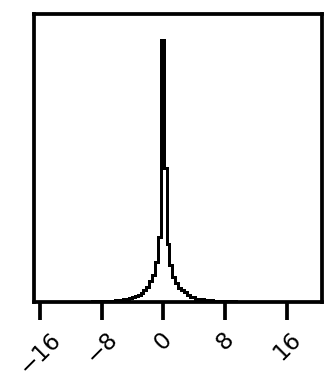

In [69]:
fig = corner.corner(res_tuple.X[:, :10], bins=100)

### Entropy

In this example, we're going to be using a synthetically created uniform distribution with independent marginals. This is actually very similar to the above example but we have to be a bit creative for this example. It stems from the properties of the uniform distribution in general.

**Multivariate Uniform Distribution**

* Each $\mathbf{x}_j$ has a uniform distribution between 0 and 1.
* Any set of $n$ $\mathbf{x}_j$'s have a uniform distribution within an N-dimensional unit hypercube.
* Each of the $\mathbf{x}_j$ can be regarded as independent no matter how large $N$ is.

This is a problem for random number generators and so they cannot really effectively generate a true multivariate normal distribution with independent marginals.

---

We still have the same relationship for a transformed variable:

$$
H(\mathbf{X}) = H(\mathbf{Z}) + \log\left| \mathbf{A} \right|
$$

So to handle this, we will generate a synthetic dataset where we have independent marginal distributions. So we are ensuring that the there is no joint information for the total entropy st:

$$
H(\mathbf{Z}) = \sum_j^D H(\mathbf{z}_j)
$$

Now we can simplify this such that we replace the joint entropy with the summation:

$$
H(\mathbf{X}) = \sum_{i}^{D} H(\mathbf{z}_j) + \log\left| \mathbf{A} \right|
$$


**Note**: This method does introduce biases with the ground truth because we still need to estimate the marginal entropy. However, we account for this by using many more samples than what will be asked (e.g. 5e5) to ensure ample sampling. In addition, we have confidence in univariate entropy estimators, e.g. histogram, KDE, K-NN, etc.


In [70]:
res_tuple.H

1.0207834632254125

### Estimators

In [71]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 2.0329 | Time: 0.0010 secs
KNN (Neighbours): 1.4317  | Time: 0.2791 secs
KNN (epsilon): 1.4317 | Time: 0.2183 secs


### T-Student

In [78]:
from pysim.data.information.studentt import generate_studentt_data

In [79]:
# create seed (trial number)
df = 5.0
res_tuple = generate_studentt_data(
    n_samples=n_samples,
    n_features=n_features,
    df=df,
    seed=seed,
    n_base_samples=500_000,
)

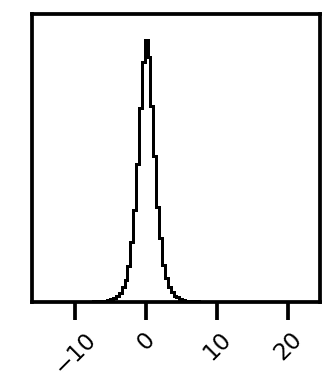

In [81]:
fig = corner.corner(res_tuple.X[:, :10], bins=100)

#### Entropy

This has a closed-form solution as found in the paper by [ Guerrero-Cusumano et al (1996)](https://www.sciencedirect.com/science/article/pii/0020025596000448) (eqn 8). 

$$
\begin{aligned}
H(D,\nu, \boldsymbol{\Sigma}) &= \frac{1}{2}\log \left|\boldsymbol{\Sigma} \right| \\
&+ \log \left[ \frac{((\nu-2) \pi)^{\frac{D}{2}}}{\Gamma\left(\frac{D}{2} \right)}  \beta \left( \frac{D}{2},\frac{\nu}{2} \right)\right] \\
&+ \frac{\nu + D}{2} \left[ \psi\left( \frac{\nu + D}{2} \right)-\psi\left( \frac{\nu}{2} \right) \right]
\end{aligned}
$$

**Note**: This is **only** for the case where the degrees of freedom, $\nu$ is greater or equal to 2.

In [82]:
res_tuple.H

1.4979123481675516

#### Estimators

In [83]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 1.8066 | Time: 0.0010 secs
KNN (Neighbours): 1.7533  | Time: 0.2828 secs
KNN (epsilon): 1.7533 | Time: 0.2272 secs


### Cauchy

This is a special case of the T-Student Distribution when the degrees of freedom, $\nu$, is equal to 1. 

In [84]:
# create seed (trial number)
df = 1.0
res_tuple = generate_studentt_data(
    n_samples=n_samples,
    n_features=n_features,
    df=df,
    seed=seed,
    n_base_samples=500_000,
)

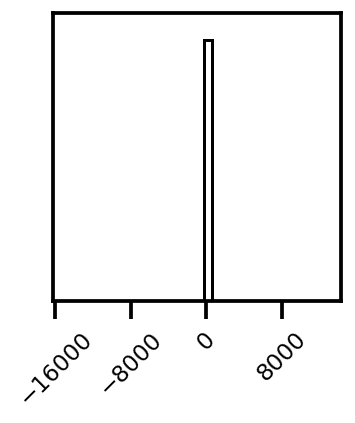

In [87]:
fig = corner.corner(res_tuple.X[:, :10], hist_bin_factor=2)

#### Entropy


Again, this has a closed-form solution as found in the paper by [ Guerrero-Cusumano et al (1996)](https://www.sciencedirect.com/science/article/pii/0020025596000448) (eqn ...). 

$$
\begin{aligned}
H(D,\nu, \boldsymbol{\Sigma}) &= \frac{1}{2}\log \left|\boldsymbol{\Sigma} \right| \\
&+ \log \left[ \frac{(\pi)^{\frac{D}{2}}}{\Gamma\left(\frac{D}{2} \right)}  \beta \left( \frac{D}{2},\frac{1}{2} \right)\right] \\
&+ \frac{1 + D}{2} \left[ \psi\left( \frac{1 + D}{2} \right)-\psi\left( \frac{1}{2} \right) \right]
\end{aligned}
$$

**Note**: This is **only** for the case where the degrees of freedom, $\nu$ is greater or equal to 2.

In [88]:
res_tuple.H

2.656846734605442

In [89]:
get_entropy_estimators(res_tuple.X.copy())

Gaussian: 6.2733 | Time: 0.0010 secs
KNN (Neighbours): 2.6619  | Time: 0.2774 secs
KNN (epsilon): 2.6619 | Time: 0.2152 secs
